DeepEdit is an algorithm that combines the power of two models in one single architecture. It allows the user to perform inference, as a standard segmentation method (i.e. UNet), and also to interactively segment part of an image using clicks (Sakinis et al.). DeepEdit aims to facilitate the user experience and at the same time the development of new active learning techniques.


This Notebooks shows the performance of a model trained to segment the spleen. 

**Once the model is trained, we recommend importing the pretrained model into the [DeepEdit App in MONAI Label](https://github.com/Project-MONAI/MONAILabel/tree/main/sample-apps/radiology#deepedit) for full experience.**

Sakinis et al., Interactive segmentation of medical images through fully convolutional neural networks. (2019) https://arxiv.org/abs/1903.08205

## DeepEdit Inference Tutorial

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib==3.5.2
!pip install -q pytorch-ignite==0.4.8

%matplotlib inline

#### Library versions used:

monai-weekly==0.9.dev2219 itk==5.2.1.post1 matplotlib==3.5.2 nibabel==3.2.2 numpy==1.22.3 pytorch-ignite==0.4.8 scikit-image==0.19.2 scipy==1.8.0 tensorboard==2.8.0 torch==1.11.0 tqdm==4.64.0

In [2]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import matplotlib.pyplot as plt
import numpy as np
import torch

import monai
from monai.config import print_config

from monai.apps.deepedit.transforms import (
    AddGuidanceSignalDeepEditd,
    AddGuidanceFromPointsDeepEditd,
    ResizeGuidanceMultipleLabelDeepEditd,
)


from monai.transforms import (
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Orientationd,
    Resized,
    ScaleIntensityRanged,
    SqueezeDimd,
    ToNumpyd,
    ToTensord,
)

from monai.networks.nets import DynUNet

print_config()

MONAI version: 0.9.1
Numpy version: 1.19.5
Pytorch version: 1.10.1+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /home/yuchengt/anaconda3/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.1
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.11.2+cu111
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.8.0
pandas version: 1.1.5
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Plotting functions

In [3]:
def draw_points(guidance, slice_idx):
    if guidance is None:
        return
    for p in guidance:
        p1 = p[1]
        p2 = p[0]
        plt.plot(p1, p2, "r+", 'MarkerSize', 30)


def show_image(image, label, guidance=None, slice_idx=None):
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")

    if label is not None:
        masked = np.ma.masked_where(label == 0, label)
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)

    draw_points(guidance, slice_idx)
    plt.colorbar()

    if label is not None:
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label)
        plt.colorbar()
        # draw_points(guidance, slice_idx)
    plt.show()


def print_data(data):
    for k in data:
        v = data[k]

        d = type(v)
        if type(v) in (int, float, bool, str, dict, tuple):
            d = v
        elif hasattr(v, 'shape'):
            d = v.shape

        if k in ('image_meta_dict', 'label_meta_dict'):
            for m in data[k]:
                print('{} Meta:: {} => {}'.format(k, m, data[k][m]))
        else:
            print('Data key: {} = {}'.format(k, d))

### Network definition

In [4]:
# labels
labels = {'spleen': 1,
          'background': 0
          }

spatial_size = [128, 128, 128]


model = DynUNet(
            spatial_dims=3,
            in_channels=len(labels) + 1,
            out_channels=len(labels),
            kernel_size=[3, 3, 3, 3, 3, 3],
            strides=[1, 2, 2, 2, 2, [2, 2, 1]],
            upsample_kernel_size=[2, 2, 2, 2, [2, 2, 1]],
            norm_name="instance",
            deep_supervision=False,
            res_block=True,
        )

In [5]:
# Download data and model

resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/_image.nii.gz"
dst = "_image.nii.gz"

if not os.path.exists(dst):
    monai.apps.download_url(resource, dst)

resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/\
download/0.8.1/pretrained_deepedit_dynunet-final.pt"
dst = "pretrained_deepedit_dynunet-final.pt"

if not os.path.exists(dst):
    monai.apps.download_url(resource, dst)

_image.nii.gz: 29.5MB [00:03, 9.24MB/s]                                         

2022-09-06 12:47:41,670 - INFO - Downloaded: _image.nii.gz
2022-09-06 12:47:41,671 - INFO - Expected md5 is None, skip md5 check for file _image.nii.gz.



pretrained_deepedit_dynunet-final.pt: 118MB [00:12, 10.3MB/s]                   

2022-09-06 12:47:53,770 - INFO - Downloaded: pretrained_deepedit_dynunet-final.pt
2022-09-06 12:47:53,771 - INFO - Expected md5 is None, skip md5 check for file pretrained_deepedit_dynunet-final.pt.


LoadImaged => image shape: (392, 392, 210)


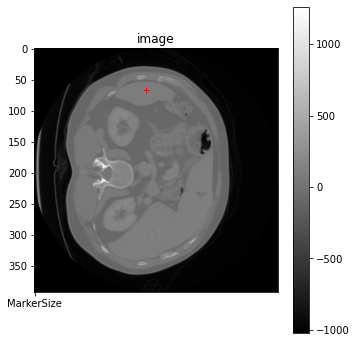

EnsureChannelFirstd => image shape: (1, 392, 392, 210)
Orientationd => image shape: (1, 392, 392, 210)
ScaleIntensityRanged => image shape: (1, 392, 392, 210)
AddGuidanceFromPointsDeepEditd => image shape: (1, 392, 392, 210)
Resized => image shape: (1, 128, 128, 128)
ResizeGuidanceMultipleLabelDeepEditd => image shape: (1, 128, 128, 128)
AddGuidanceSignalDeepEditd => image shape: (3, 128, 128, 128)
ToTensord => image shape: torch.Size([3, 128, 128, 128])


In [6]:
# spleen label points are demoed:     'spleen': [[66, 180, 105], [66, 180, 145]].
data = {
    'image': '_image.nii.gz',
    'spleen': [[66, 180, 105], [66, 180, 145]],
    'background': [],
}
# Other organs/targets will follow, change 'spleen' in the following keys: e.g., "liver", "kidney", etc
slice_idx = original_slice_idx = data['spleen'][0][2]

# Pre Processing

pre_transforms = [
    # Loading the image
    LoadImaged(keys="image", reader="ITKReader"),
    # Ensure channel first
    EnsureChannelFirstd(keys="image"),
    # Change image orientation
    Orientationd(keys="image", axcodes="RAS"),
    # Scaling image intensity - works well for CT images
    ScaleIntensityRanged(keys="image", a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    # DeepEdit Tranforms for Inference #
    # Add guidance (points) in the form of tensors based on the user input
    AddGuidanceFromPointsDeepEditd(ref_image="image", guidance="guidance", label_names=labels),
    # Resize the image
    Resized(keys="image", spatial_size=spatial_size, mode="area"),
    # Resize the guidance based on the image resizing
    ResizeGuidanceMultipleLabelDeepEditd(guidance="guidance", ref_image="image"),
    # Add the guidance to the input image
    AddGuidanceSignalDeepEditd(keys="image", guidance="guidance"),
    # Convert image to tensor
    ToTensord(keys="image"),
]

original_image = None

# Going through each of the pre_transforms

for t in pre_transforms:
    tname = type(t).__name__
    data = t(data)
    image = data['image']
    label = data.get('label')
    guidance = data.get('guidance')
    print("{} => image shape: {}".format(tname, image.shape))

    if tname == 'LoadImaged':
        original_image = data['image']
        label = None
        tmp_image = image[:, :, slice_idx]
        # Change 'spleen' in the following keys if other target is chosen.
        show_image(tmp_image, label, [data['spleen'][0]], slice_idx)

transformed_image = data['image']
guidance = data.get('guidance')


EnsureTyped => image shape: torch.Size([3, 128, 128, 128]), pred shape: (2, 128, 128, 128)
Activationsd => image shape: torch.Size([3, 128, 128, 128]), pred shape: (2, 128, 128, 128)
AsDiscreted => image shape: torch.Size([3, 128, 128, 128]), pred shape: (1, 128, 128, 128)
SqueezeDimd => image shape: torch.Size([3, 128, 128, 128]), pred shape: (128, 128, 128)
ToNumpyd => image shape: torch.Size([3, 128, 128, 128]), pred shape: (128, 128, 128)
Final PLOT:: 50 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 23.0


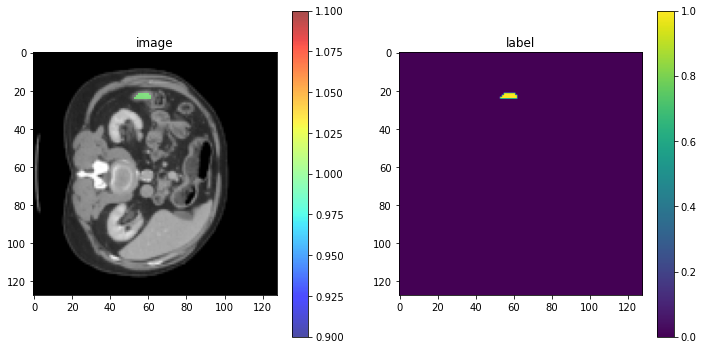

Final PLOT:: 60 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 205.0


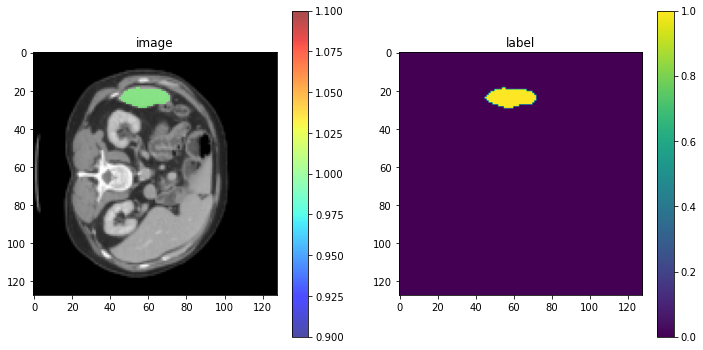

Final PLOT:: 70 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 319.0


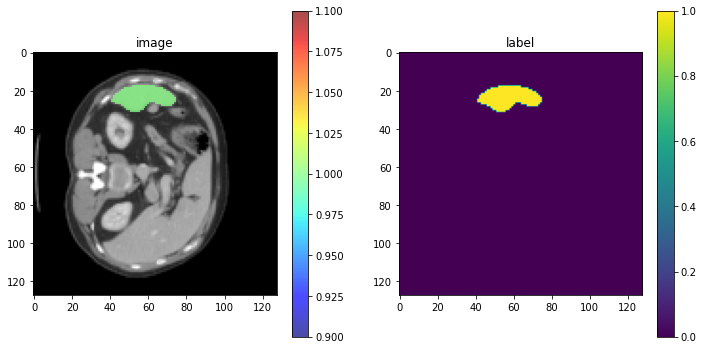

Final PLOT:: 80 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 389.0


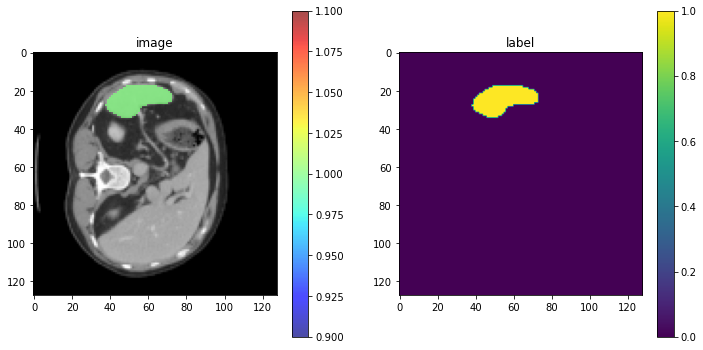

Final PLOT:: 90 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 383.0


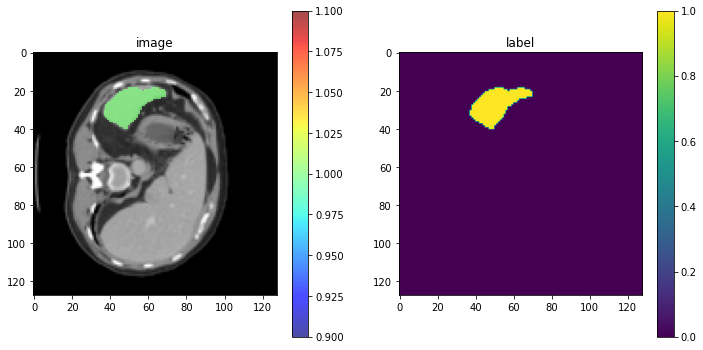

Final PLOT:: 100 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 315.0


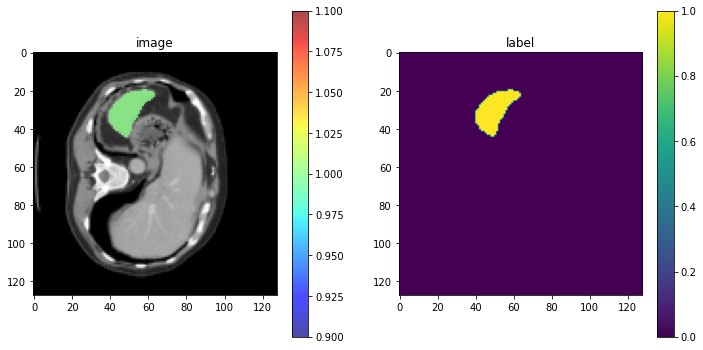

In [7]:
# Evaluation
model_path = 'pretrained_deepedit_dynunet-final.pt'
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()

inputs = data['image'][None].cuda()
with torch.no_grad():
    outputs = model(inputs)
outputs = outputs[0]
data['pred'] = outputs

post_transforms = [
    EnsureTyped(keys="pred"),
    Activationsd(keys="pred", softmax=True),
    AsDiscreted(keys="pred", argmax=True),
    SqueezeDimd(keys="pred", dim=0),
    ToNumpyd(keys="pred"),
]

pred = None
for t in post_transforms:
    tname = type(t).__name__
    data = t(data)
    image = data['image']
    label = data['pred']
    print("{} => image shape: {}, pred shape: {}".format(tname, image.shape, label.shape))

for i in range(10, 110, 10):
    image = transformed_image[0, :, :, i]  # Taking the first channel which is the main image
    label = data['pred'][:, :, i]
    if np.sum(label) == 0:
        continue

    print("Final PLOT:: {} => image shape: {}, pred shape: {}; min: {}, max: {}, sum: {}".format(
        i, image.shape, label.shape, np.min(label), np.max(label), np.sum(label)))
    show_image(image, label)

In [33]:
# remove downloaded files
os.remove('_image.nii.gz')
os.remove('pretrained_deepedit_dynunet-final.pt')